In [78]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                            roc_curve, auc, precision_recall_curve, f1_score)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
import pickle
import warnings
import time
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")


In [79]:
# 1. Load the dataset
df = pd.read_csv('data/heart_disease_uci.csv')

In [80]:
print("\nFirst 5 rows:")
df.head()


First 5 rows:


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [81]:
# 2. Basic data exploration
print("Dataset shape:", df.shape)
print("\nBasic statistics:")
df.describe()


Dataset shape: (920, 16)

Basic statistics:


,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


In [82]:
# Check for missing values (important!)
print("\nMissing values per column:")
missing_values = df.isnull().sum()
print(missing_values)
print(f"\nTotal missing values: {missing_values.sum()}")


Missing values per column:
id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

Total missing values: 1759


In [83]:
print(df.columns)


Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')


In [84]:
print("\nHandling missing values...")
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

print(f"Remaining missing values: {df.isnull().sum().sum()}")


Handling missing values...
Remaining missing values: 0


In [85]:
# 5. Feature engineering
print("\nPerforming feature engineering...")

# Create binary target (0 for no disease, 1+ for disease)
df['target'] = df['num'].apply(lambda x: 0 if x == 0 else 1)

# Display target distribution
print("\nTarget distribution:")
print(df['target'].value_counts())
print(f"Percentage with heart disease: {df['target'].mean()*100:.2f}%")

# Drop unnecessary columns
print("\nDropping unnecessary columns...")
df = df.drop(['id', 'dataset', 'num'], axis=1)



Performing feature engineering...

Target distribution:
target
1    509
0    411
Name: count, dtype: int64
Percentage with heart disease: 55.33%

Dropping unnecessary columns...



----- Data Visualization -----


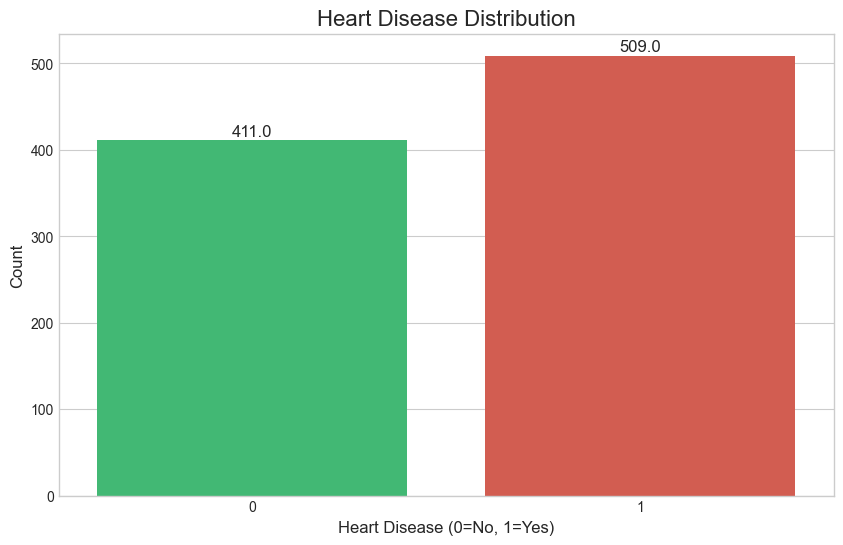

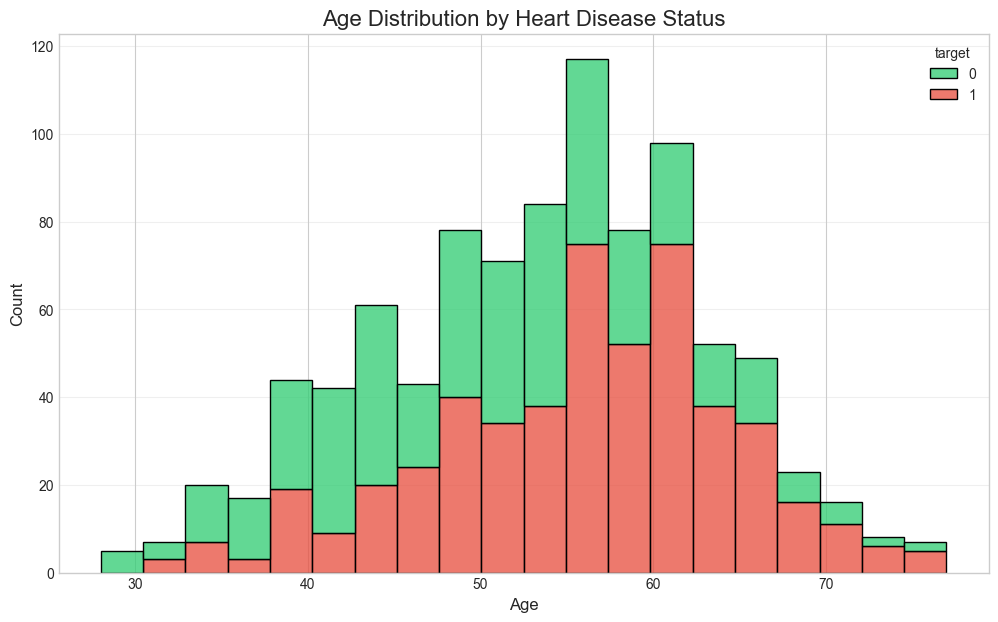

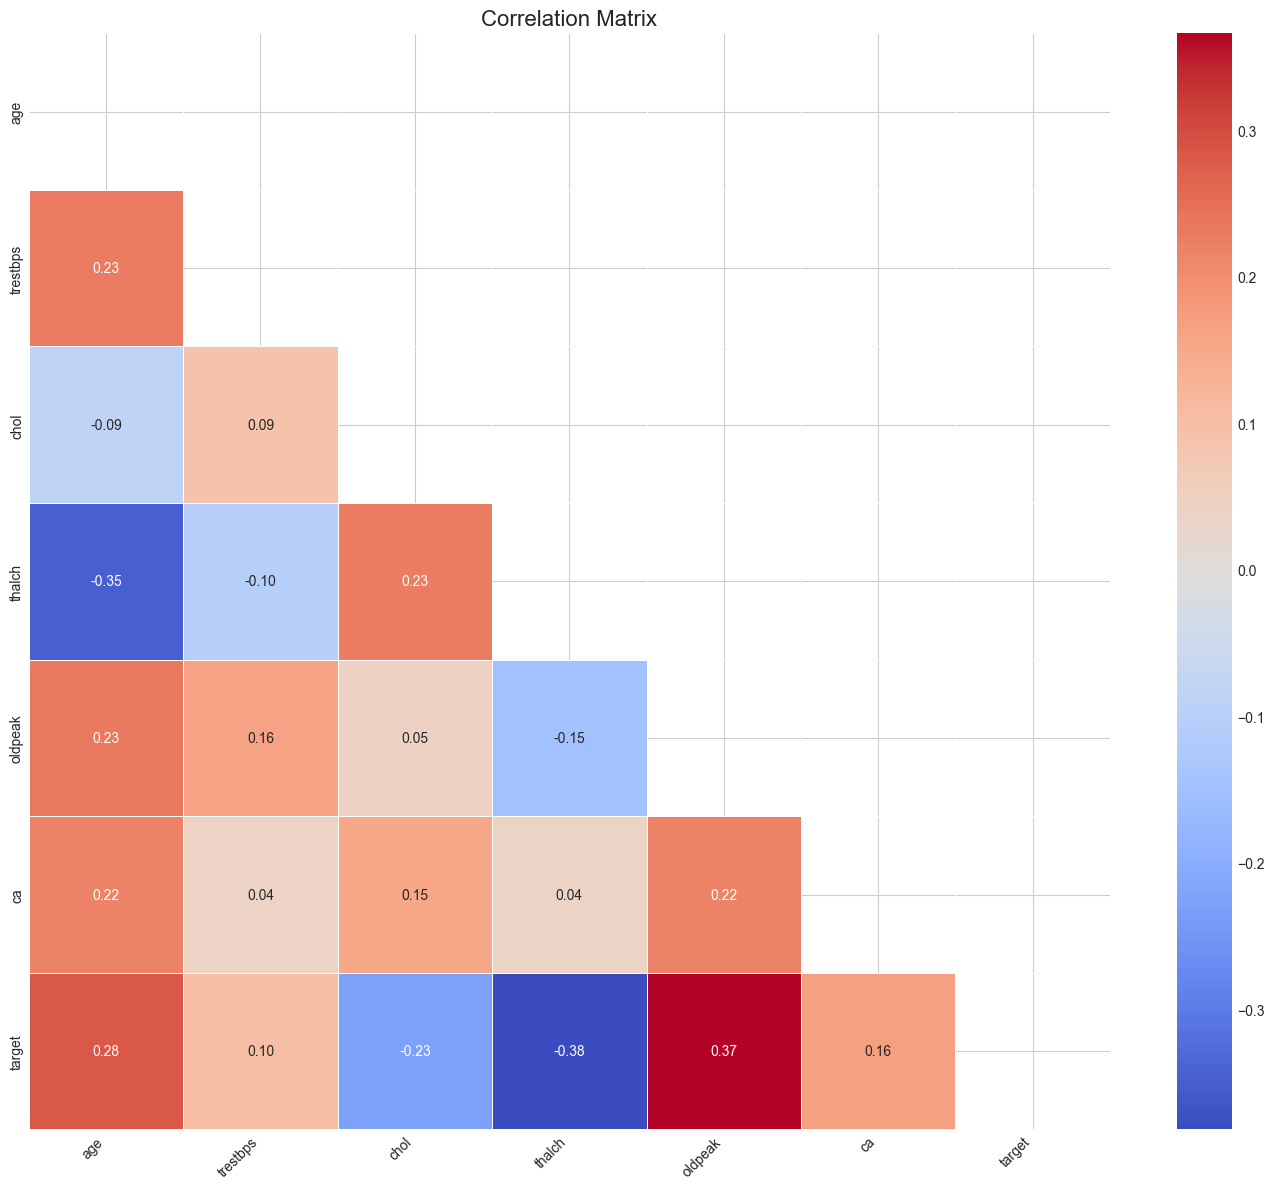

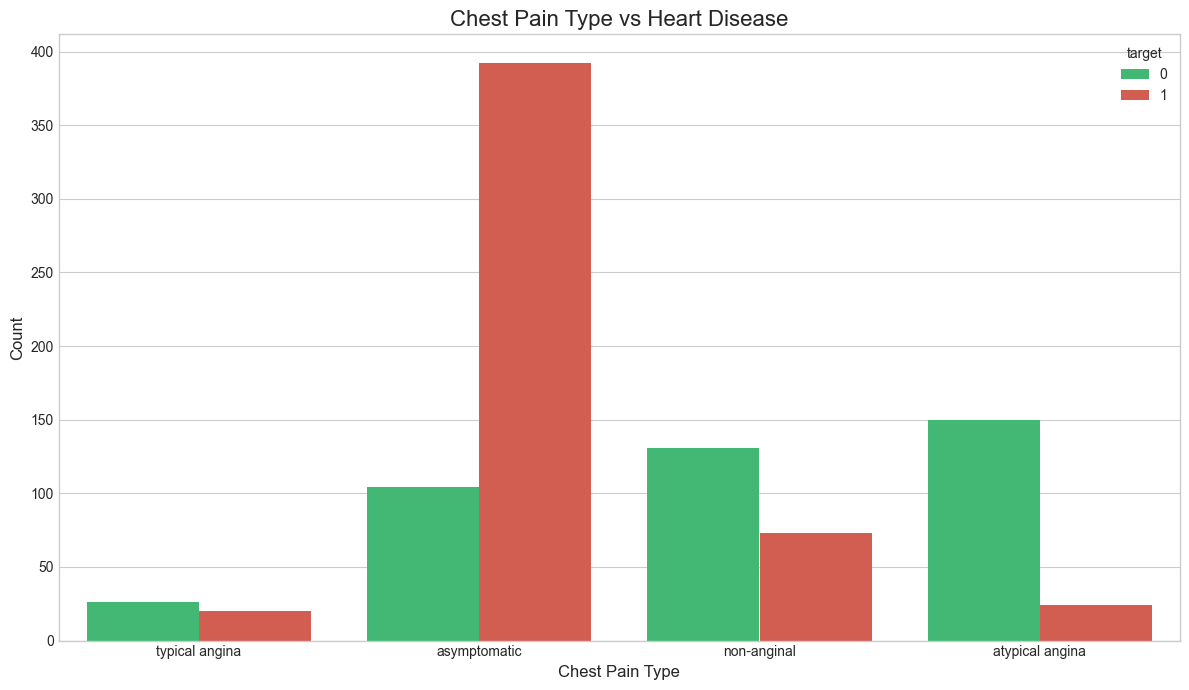

In [86]:
# . Data visualization
print("\n----- Data Visualization -----")

# Plot target distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='target', data=df, palette=['#2ecc71', '#e74c3c'])
plt.title('Heart Disease Distribution', fontsize=16)
plt.xlabel('Heart Disease (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width()/2., p.get_height() + 5),
                ha='center', fontsize=12)

plt.show()
# Visualize age distribution by heart disease
plt.figure(figsize=(12, 7))
sns.histplot(data=df, x='age', hue='target', multiple='stack', bins=20, palette=['#2ecc71', '#e74c3c'])
plt.title('Age Distribution by Heart Disease Status', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

# Check correlation between numerical features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(14, 12))
corr_matrix = df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualize the relationship between chest pain type and target
plt.figure(figsize=(12, 7))
ax = sns.countplot(x='cp', hue='target', data=df, palette=['#2ecc71', '#e74c3c'])
plt.title('Chest Pain Type vs Heart Disease', fontsize=16)
plt.xlabel('Chest Pain Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()


In [87]:
#  Prepare data for modeling
print("\n----- Data Preparation -----")
X = df.drop('target', axis=1)
y = df['target']

# Handle categorical features with one-hot encoding
print("Applying one-hot encoding to categorical features...")
X = pd.get_dummies(X, drop_first=True)
print(f"Features after encoding: {X.shape[1]}")


----- Data Preparation -----
Applying one-hot encoding to categorical features...
Features after encoding: 18


In [88]:
#  Split and scale data
print("\n----- Data Splitting and Scaling -----")
# First split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")



----- Data Splitting and Scaling -----
Training set: 736 samples
Testing set: 184 samples


In [89]:
# Scale the features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Scaling features...


In [90]:
print("\n4. Performing feature selection...")
selector = SelectKBest(f_classif, k=15)  # Increased from 10 to 15 features
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names for interpretation
feature_indices = selector.get_support(indices=True)
selected_features = X.columns[feature_indices]
print("Top 15 selected features:")
for i, feature in enumerate(selected_features):
    print(f"  {i+1}. {feature}")


4. Performing feature selection...
Top 15 selected features:
  1. age
  2. trestbps
  3. chol
  4. thalch
  5. exang
  6. oldpeak
  7. ca
  8. sex_Male
  9. cp_atypical angina
  10. cp_non-anginal
  11. restecg_normal
  12. restecg_st-t abnormality
  13. slope_upsloping
  14. thal_normal
  15. thal_reversable defect


In [91]:
print("\n4.5 Applying SMOTE for class balancing...")
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

# Check class distribution after balancing
print("Class distribution before SMOTE:", np.bincount(y_train))
print("Class distribution after SMOTE:", np.bincount(y_train_balanced))


4.5 Applying SMOTE for class balancing...
Class distribution before SMOTE: [329 407]
Class distribution after SMOTE: [407 407]


In [92]:
# Replace the models_with_params in cell 13 with:
print("\n5. Performing cross-validation and hyperparameter tuning...")

# Define models with expanded hyperparameter grids
models_with_params = {
    "XGBoost": {
        'model': XGBClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7, 9],
            'min_child_weight': [1, 3],
            'subsample': [0.8, 1.0],
            'gamma': [0, 0.1]
        }
    },
    "Random Forest": {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 15, 30],
            'min_samples_split': [2, 5],
            'max_features': ['sqrt', None]
        }
    },
    "Gradient Boosting": {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        }
    }
}


5. Performing cross-validation and hyperparameter tuning...


In [93]:
# Replace the grid search in cell 14 with:
from sklearn.model_selection import RandomizedSearchCV

best_models = {}
cv_results = {}

for name, model_info in models_with_params.items():
    print(f"\nTuning {name}...")
    
    # Create 5-fold stratified cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Use RandomizedSearchCV for more efficient searching
    random_search = RandomizedSearchCV(
        estimator=model_info['model'],
        param_distributions=model_info['params'],
        n_iter=20,  # Try 20 combinations
        cv=cv,
        scoring='accuracy',  # Switched to accuracy since that's our goal
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    # Fit on the balanced data
    try:
        random_search.fit(X_train_balanced, y_train_balanced)
        best_models[name] = random_search.best_estimator_
        
        # Log results
        cv_results[name] = {
            'best_params': random_search.best_params_,
            'best_cv_score': random_search.best_score_
        }
        
        print(f"  Best parameters: {random_search.best_params_}")
        print(f"  Best CV accuracy: {random_search.best_score_:.4f}")
    except Exception as e:
        print(f"Error tuning {name}: {str(e)}")


Tuning XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
  Best parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0}
  Best CV accuracy: 0.8256

Tuning Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
  Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 30}
  Best CV accuracy: 0.8329

Tuning Gradient Boosting...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
  Best parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01}
  Best CV accuracy: 0.8329


In [94]:
print("\n8. Creating ensemble model for higher accuracy...")

# Create a voting ensemble of our best models
from sklearn.ensemble import VotingClassifier

# Take the best models
print("Creating voting ensemble from best models...")
estimators = [(name, model) for name, model in best_models.items()]
ensemble = VotingClassifier(estimators=estimators, voting='soft')

# Train the ensemble on balanced data
ensemble.fit(X_train_balanced, y_train_balanced)

# Evaluate ensemble
y_train_pred_ensemble = ensemble.predict(X_train_selected)
y_test_pred_ensemble = ensemble.predict(X_test_selected)

# Calculate metrics
train_acc_ens = accuracy_score(y_train, y_train_pred_ensemble)
test_acc_ens = accuracy_score(y_test, y_test_pred_ensemble)
test_f1_ens = f1_score(y_test, y_test_pred_ensemble)

print(f"Ensemble Model Results:")
print(f"  Training Accuracy: {train_acc_ens:.4f}")
print(f"  Testing Accuracy: {test_acc_ens:.4f}")
print(f"  Testing F1 Score: {test_f1_ens:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred_ensemble))

# Add ensemble to our results
best_models['Ensemble'] = ensemble
test_results['Ensemble'] = {'accuracy': test_acc_ens, 'f1': test_f1_ens}

# If ensemble is better, update best model
if test_acc_ens > best_metrics['accuracy']:
    print("\nEnsemble model outperforms other models!")
    best_model_name = 'Ensemble'
    best_model = ensemble
    best_metrics = {'accuracy': test_acc_ens, 'f1': test_f1_ens}


8. Creating ensemble model for higher accuracy...
Creating voting ensemble from best models...
Ensemble Model Results:
  Training Accuracy: 0.9171
  Testing Accuracy: 0.8478
  Testing F1 Score: 0.8641

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83        82
           1       0.86      0.87      0.86       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.85       184
weighted avg       0.85      0.85      0.85       184




7. Comparing models...


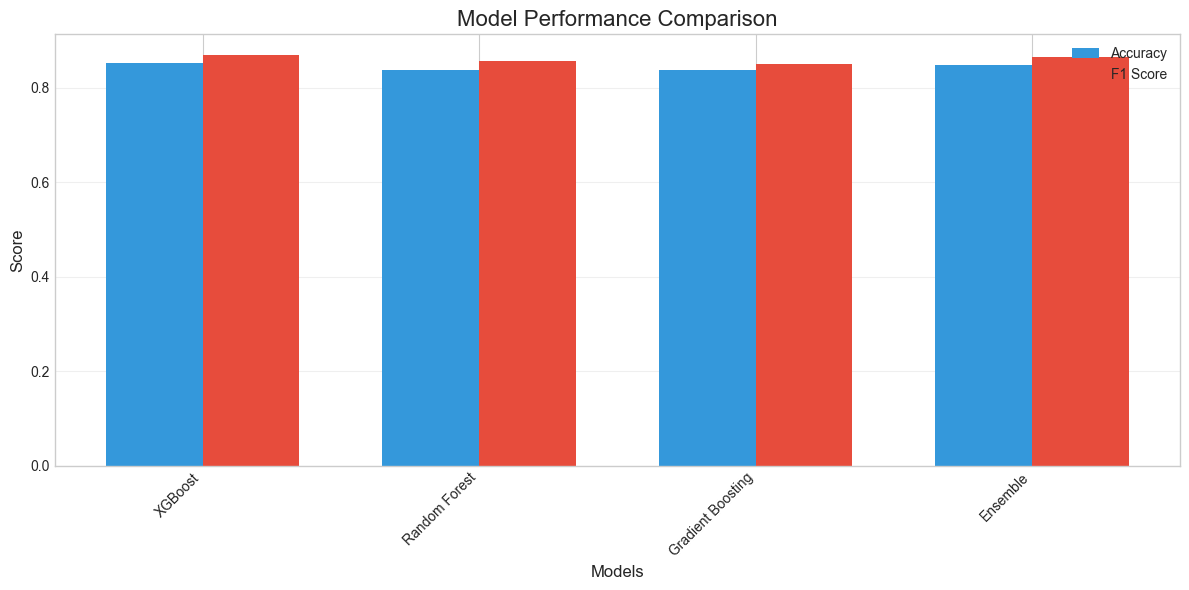

In [95]:
# =====================
# Model Comparison
# =====================
print("\n7. Comparing models...")

# Create comparison chart
plt.figure(figsize=(12, 6))

# Extract metrics
model_names = list(test_results.keys())
test_accuracy = [test_results[name]['accuracy'] for name in model_names]
test_f1 = [test_results[name]['f1'] for name in model_names]

# Plot comparison
x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, test_accuracy, width, label='Accuracy', color='#3498db')
plt.bar(x + width/2, test_f1, width, label='F1 Score', color='#e74c3c')

plt.xlabel('Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Comparison', fontsize=16)
plt.xticks(x, model_names, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [96]:
# Find the best model based on F1 score
best_model_name = max(test_results, key=lambda x: test_results[x]['f1'])
best_model = best_models[best_model_name]
best_metrics = test_results[best_model_name]

print(f"\nBest model: {best_model_name}")
print(f"Test Accuracy: {best_metrics['accuracy']:.4f}")
print(f"Test F1 Score: {best_metrics['f1']:.4f}")
print(f"Best parameters: {cv_results[best_model_name]['best_params']}")


Best model: XGBoost
Test Accuracy: 0.8533
Test F1 Score: 0.8696
Best parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0}


In [99]:
# . Detailed evaluation of best model
print("\n----- Best Model Evaluation -----")

# Get predictions
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'{best_model_name} Confusion Matrix', fontsize=16)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)


----- Best Model Evaluation -----


ValueError: Feature shape mismatch, expected: 15, got 18

<Figure size 640x480 with 0 Axes>

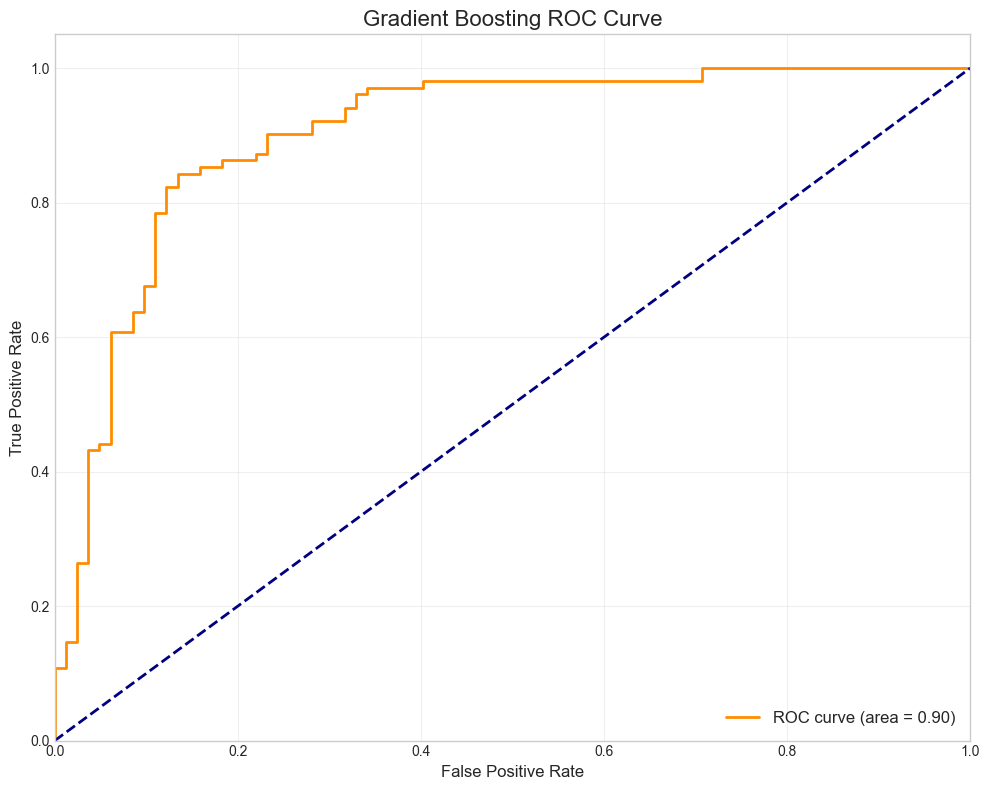

In [ ]:
# Add metrics text
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

plt.figtext(0.5, 0.01, f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}", 
            ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'{best_model_name} ROC Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
